In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from collections import OrderedDict
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

Loading data and preliminary skimming

In [168]:
data_051 = pd.read_excel('dataset/051.xlsx')
max_feed = data_051.loc[data_051['label'] == 1]['timestamp'].max()
min_feed = data_051.loc[data_051['label'] == 1]['timestamp'].min()
max_feed = datetime.datetime.fromtimestamp(max_feed/1000.0)
min_feed = datetime.datetime.fromtimestamp(min_feed/1000.0)
feed_time = max_feed-min_feed
#0
print('mulai makan: ' +str(min_feed))
print('akhir makan: ' + str(max_feed))
print('lama makan: ' + str(max_feed-min_feed))
max_afk = data_051.loc[data_051['label'] == 0]['timestamp'].max()
min_afk = data_051.loc[data_051['label'] == 0]['timestamp'].min()
max_afk = datetime.datetime.fromtimestamp(max_afk/1000.0)
min_afk = datetime.datetime.fromtimestamp(min_afk/1000.0)
afk_time = max_afk-min_afk
#1
print('mulai afk: ' +str(min_afk))
print('akhir afk: ' + str(max_afk))


mulai makan: 2022-07-06 14:41:54.320000
akhir makan: 2022-07-06 14:43:38.280000
lama makan: 0:01:43.960000
mulai afk: 2022-07-06 14:43:38.320000
akhir afk: 2022-07-06 14:45:22.280000


In [169]:
data_102 = pd.read_excel('dataset/102.xlsx')
max_feed = data_102.loc[data_102['label'] == 1]['timestamp'].max()
min_feed = data_102.loc[data_102['label'] == 1]['timestamp'].min()
max_feed = datetime.datetime.fromtimestamp(max_feed/1000.0)
min_feed = datetime.datetime.fromtimestamp(min_feed/1000.0)
feed_time = max_feed-min_feed
#0
print('mulai makan: ' +str(min_feed))
print('akhir makan: ' + str(max_feed))
print('lama makan: ' + str(max_feed-min_feed))
max_afk = data_102.loc[data_102['label'] == 0]['timestamp'].max()
min_afk = data_102.loc[data_102['label'] == 0]['timestamp'].min()
max_afk = datetime.datetime.fromtimestamp(max_afk/1000.0)
min_afk = datetime.datetime.fromtimestamp(min_afk/1000.0)
afk_time = max_afk-min_afk
#1
print('mulai afk: ' +str(min_afk))
print('akhir afk: ' + str(max_afk))


mulai makan: 2022-07-06 14:53:24.880000
akhir makan: 2022-07-06 14:54:39.720000
lama makan: 0:01:14.840000
mulai afk: 2022-07-06 14:54:39.760000
akhir afk: 2022-07-06 14:55:54.600000


After I realized that all of the data are connected as one continous event, I concatted the all of the sheet data

In [170]:
data_051 = pd.read_excel('dataset/051.xlsx')
data_051 = data_051.assign(id=51)
data_101 = pd.read_excel('dataset/101.xlsx')
data_101 = data_101.assign(id=101)
data_102 = pd.read_excel('dataset/102.xlsx')
data_102 = data_102.assign(id=102)
data_103 = pd.read_excel('dataset/103.xlsx')
data_102 = data_102.assign(id=103)
data_161 = pd.read_excel('dataset/161.xlsx')
data_161 = data_161.assign(id=161)
data_162 = pd.read_excel('dataset/162.xlsx')
data_162 = data_162.assign(id=162)
data_163 = pd.read_excel('dataset/163.xlsx')
data_163 = data_163.assign(id=163)
data_list = [data_051, data_101, data_102, data_103, data_161, data_162, data_163]
df_all = pd.concat(data_list)

As the timestamp data was still in unix, I converted it into datetime

In [171]:
df_all = df_all.sort_values('timestamp')
df_all['timestamp_raw'] = df_all['timestamp']
df_all['timestamp'] = [datetime.datetime.fromtimestamp(col/1000.0) for col in df_all['timestamp']]
df_all

,timestamp,x,y,z,label,id,timestamp_raw
0,2022-07-06 14:40:02.000,-4,231,37,1,163.0,1657093202000
1,2022-07-06 14:40:02.040,7,232,33,1,163.0,1657093202040
2,2022-07-06 14:40:02.080,10,234,37,1,163.0,1657093202080
3,2022-07-06 14:40:02.120,4,242,43,1,163.0,1657093202120
4,2022-07-06 14:40:02.160,0,260,46,1,163.0,1657093202160
...,...,...,...,...,...,...,...
4571,2022-07-06 14:58:57.480,-1,243,42,0,101.0,1657094337480
4572,2022-07-06 14:58:57.520,-1,244,41,0,101.0,1657094337520
4573,2022-07-06 14:58:57.560,0,244,43,0,101.0,1657094337560
4574,2022-07-06 14:58:57.600,-2,246,44,0,101.0,1657094337600


I made a function to get the feeding times and afk times for the fish for each data

In [172]:
def get_avg_activity_time(data):
    max_feed = data.loc[data['label'] == 1]['timestamp'].max()
    min_feed = data.loc[data['label'] == 1]['timestamp'].min()
    max_feed = datetime.datetime.fromtimestamp(max_feed/1000.0)
    min_feed = datetime.datetime.fromtimestamp(min_feed/1000.0)
    feed_time = max_feed-min_feed
    #0
    print('mulai makan: ' +str(min_feed))
    print('akhir makan: ' + str(max_feed))
    print('lama makan: ' + str(max_feed-min_feed))
    max_afk = data.loc[data['label'] == 0]['timestamp'].max()
    min_afk = data.loc[data['label'] == 0]['timestamp'].min()
    max_afk = datetime.datetime.fromtimestamp(max_afk/1000.0)
    min_afk = datetime.datetime.fromtimestamp(min_afk/1000.0)
    afk_time = max_afk-min_afk
    #1
    print('mulai afk: ' +str(min_afk))
    print('akhir afk: ' + str(max_afk))
    return feed_time,afk_time, min_feed

After running the function on all of the data, I appended it to a list containing all the feed times and afk times, and also added the data into a dictionary containing all the important information regarding the time

In [205]:
all_dict = dict()
feed_time_ls = list()
afk_time_ls = list()
counter=0
for i in data_list:
    feed_time, afk_time,min_feed = get_avg_activity_time(i)
    feed_time_ls.append(feed_time)
    afk_time_ls.append(afk_time)
    all_dict[counter] = {
        'feed_time_raw': feed_time,
        'feed_time': str(feed_time),
        'afk_time': str(afk_time),
        'min_feed': str(min_feed)
    }
    counter+=1

mulai makan: 2022-07-06 14:41:54.320000
akhir makan: 2022-07-06 14:43:38.280000
lama makan: 0:01:43.960000
mulai afk: 2022-07-06 14:43:38.320000
akhir afk: 2022-07-06 14:45:22.280000
mulai makan: 2022-07-06 14:55:54.640000
akhir makan: 2022-07-06 14:57:26.120000
lama makan: 0:01:31.480000
mulai afk: 2022-07-06 14:57:26.160000
akhir afk: 2022-07-06 14:58:57.640000
mulai makan: 2022-07-06 14:53:24.880000
akhir makan: 2022-07-06 14:54:39.720000
lama makan: 0:01:14.840000
mulai afk: 2022-07-06 14:54:39.760000
akhir afk: 2022-07-06 14:55:54.600000
mulai makan: 2022-07-06 14:49:44.400000
akhir makan: 2022-07-06 14:51:34.600000
lama makan: 0:01:50.200000
mulai afk: 2022-07-06 14:51:34.640000
akhir afk: 2022-07-06 14:53:24.840000
mulai makan: 2022-07-06 14:47:18.800000
akhir makan: 2022-07-06 14:48:31.560000
lama makan: 0:01:12.760000
mulai afk: 2022-07-06 14:48:31.600000
akhir afk: 2022-07-06 14:49:44.360000
mulai makan: 2022-07-06 14:45:22.320000
akhir makan: 2022-07-06 14:46:20.520000
lama 

Ordered the dictionary based on chronological order, which in this case is the start of the feeding time, because all of the data begins with feeding first and then afk

In [174]:
all_dict = OrderedDict(sorted(all_dict.items(), key=lambda x: x[1]['min_feed'], reverse=False))

And then after I got the data, I plotted it to get context on the feeding patterns to determine the schedule of feeding

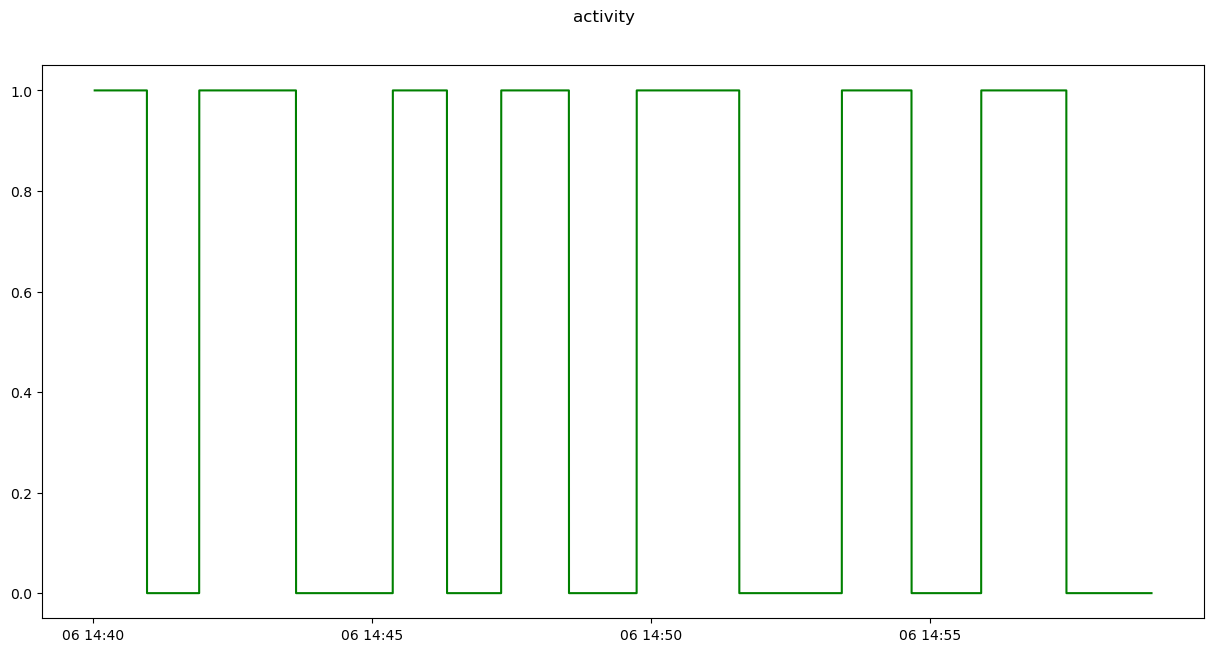

In [175]:
plot, axax = plt.subplots(nrows=1, figsize=(15, 7), sharex=True)
axax.plot(df_all['timestamp'], df_all['label'], 'g')
plt.subplots_adjust(hspace=0.2)
plot.suptitle('activity')
plt.subplots_adjust(top=0.90)
plt.show()

Added the portioning based on previous information that the total amount of feed is 5kgs, and distributed it based on duration of feeding

In [176]:
for i in all_dict:
    all_dict[i]['portion'] = all_dict[i]['feed_time_raw']/sum(feed_time_ls, datetime.timedelta(0))*5

In [177]:
all_dict

OrderedDict([(6,
              {'feed_time_raw': datetime.timedelta(seconds=56, microseconds=120000),
               'feed_time': '0:00:56.120000',
               'afk_time': '0:00:56.120000',
               'min_feed': '2022-07-06 14:40:02',
               'portion': 0.49439706815138484}),
             (0,
              {'feed_time_raw': datetime.timedelta(seconds=103, microseconds=960000),
               'feed_time': '0:01:43.960000',
               'afk_time': '0:01:43.960000',
               'min_feed': '2022-07-06 14:41:54.320000',
               'portion': 0.9158503065755162}),
             (5,
              {'feed_time_raw': datetime.timedelta(seconds=58, microseconds=200000),
               'feed_time': '0:00:58.200000',
               'afk_time': '0:00:58.200000',
               'min_feed': '2022-07-06 14:45:22.320000',
               'portion': 0.5127211219959124}),
             (4,
              {'feed_time_raw': datetime.timedelta(seconds=72, microseconds=760000),
         

Set frequency and labels

In [178]:
Fs = 25
activities = df_all['label'].value_counts().index
activities

Int64Index([1, 0], dtype='int64')

Plot the x, y, z accelerations

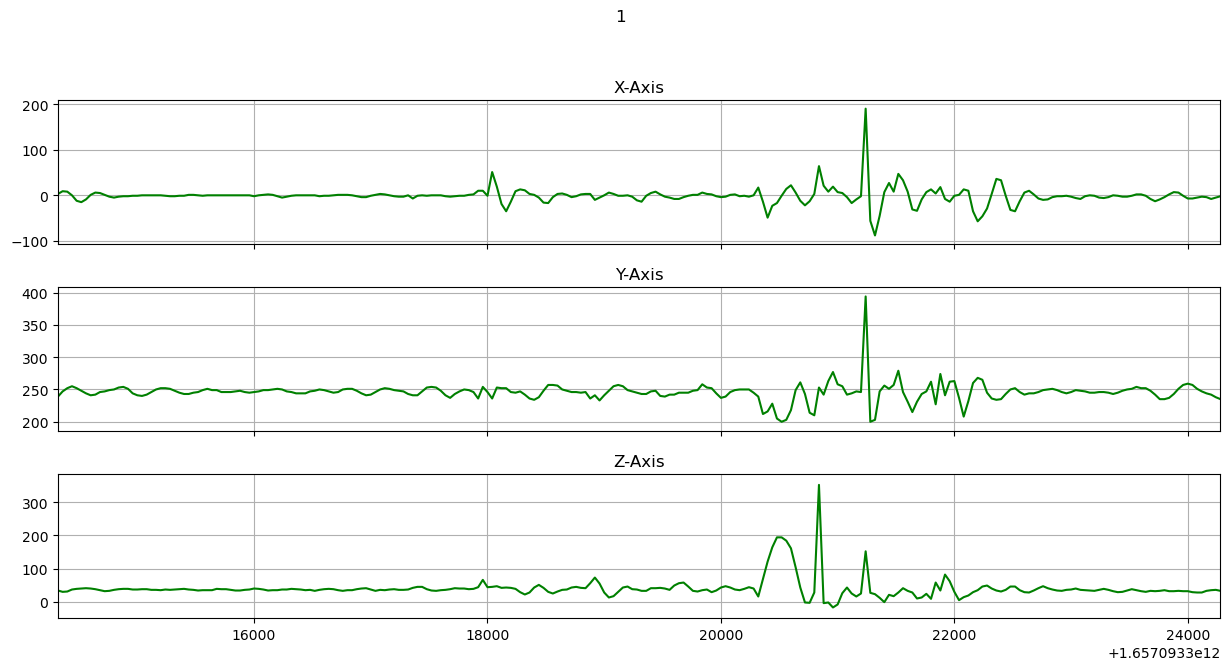

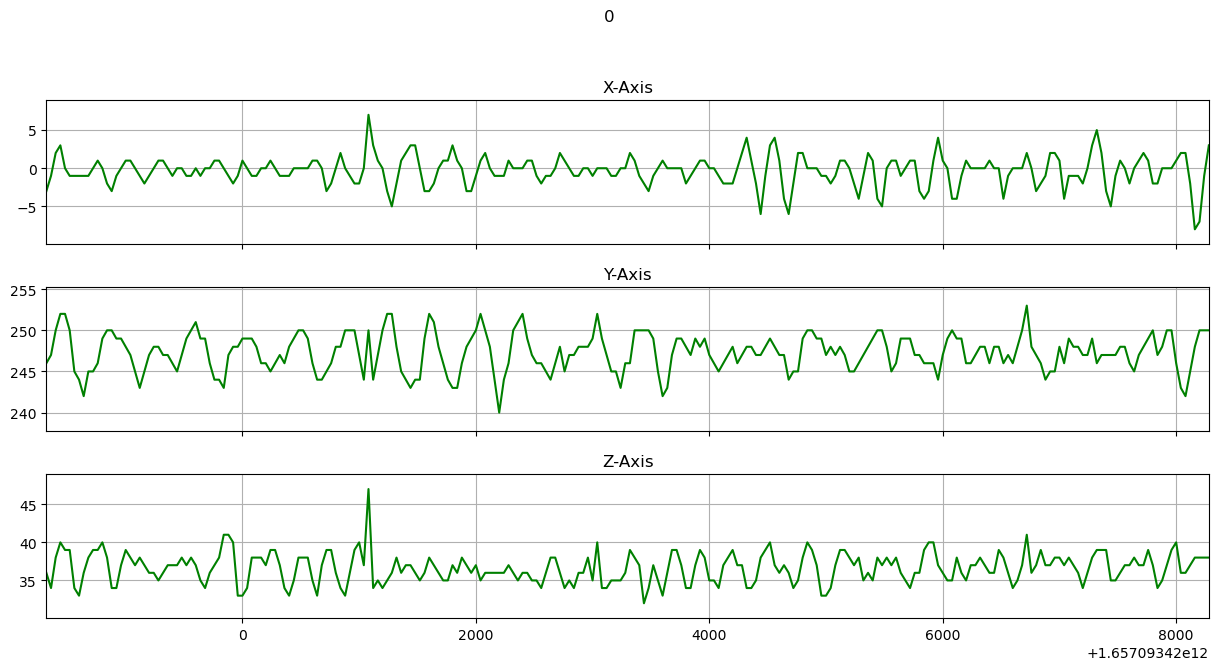

In [179]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.3)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.85)
    plt.show()

def plot_activity_fft(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['timestamp'], np.fft.fft(data['x']), 'X-Axis')
    plot_axis(ax1, data['timestamp'], np.fft.fft(data['y']), 'Y-Axis')
    plot_axis(ax2, data['timestamp'], np.fft.fft(data['x']), 'Z-Axis')
    plt.subplots_adjust(hspace=0.3)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.85)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(True)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data_051[(data_051['label'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

Plot FFT on data

c:\Users\Heliotrope\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Heliotrope\anaconda3\lib\site-packages\matplotlib\transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


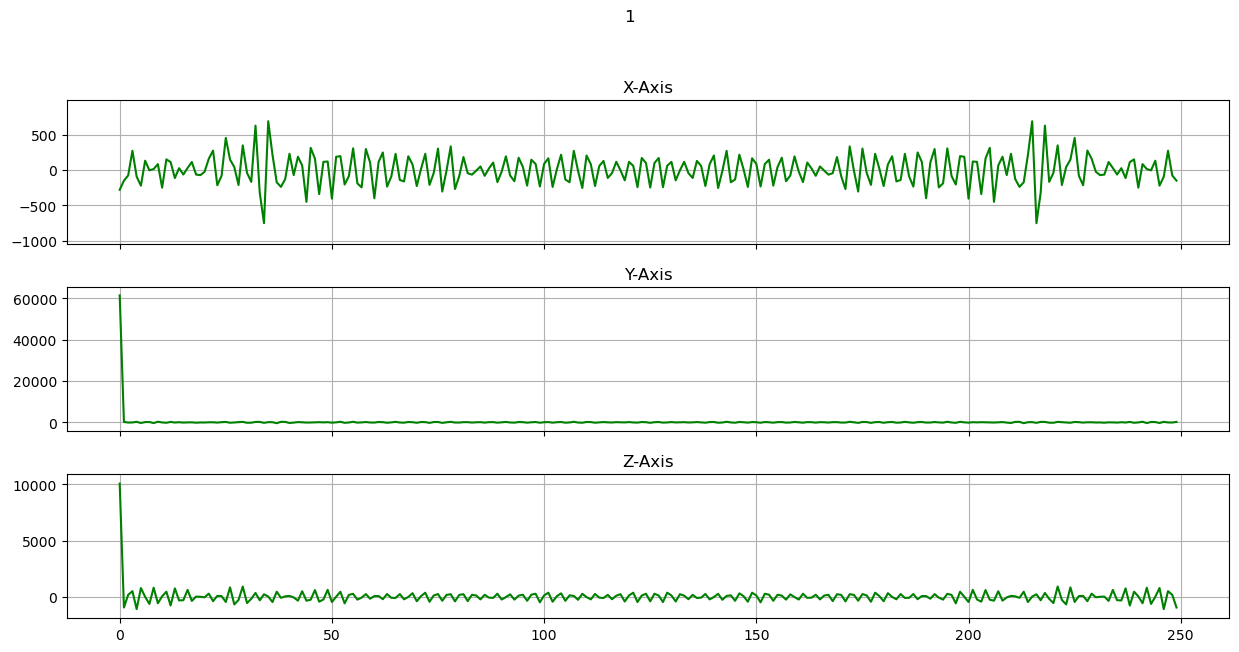

In [180]:
def plot_axis1(ax, y, title):
    ax.plot( y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(True)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

temp = data_051[(data_051['label'] == 1)][:Fs*10]
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis1(ax0,  np.fft.fft(temp['x']), 'X-Axis')
plot_axis1(ax1,  np.fft.fft(temp['y']), 'Y-Axis')
plot_axis1(ax2,  np.fft.fft(temp['z']), 'Z-Axis')
plt.subplots_adjust(hspace=0.3)
fig.suptitle(1)
plt.subplots_adjust(top=0.85)
plt.show()





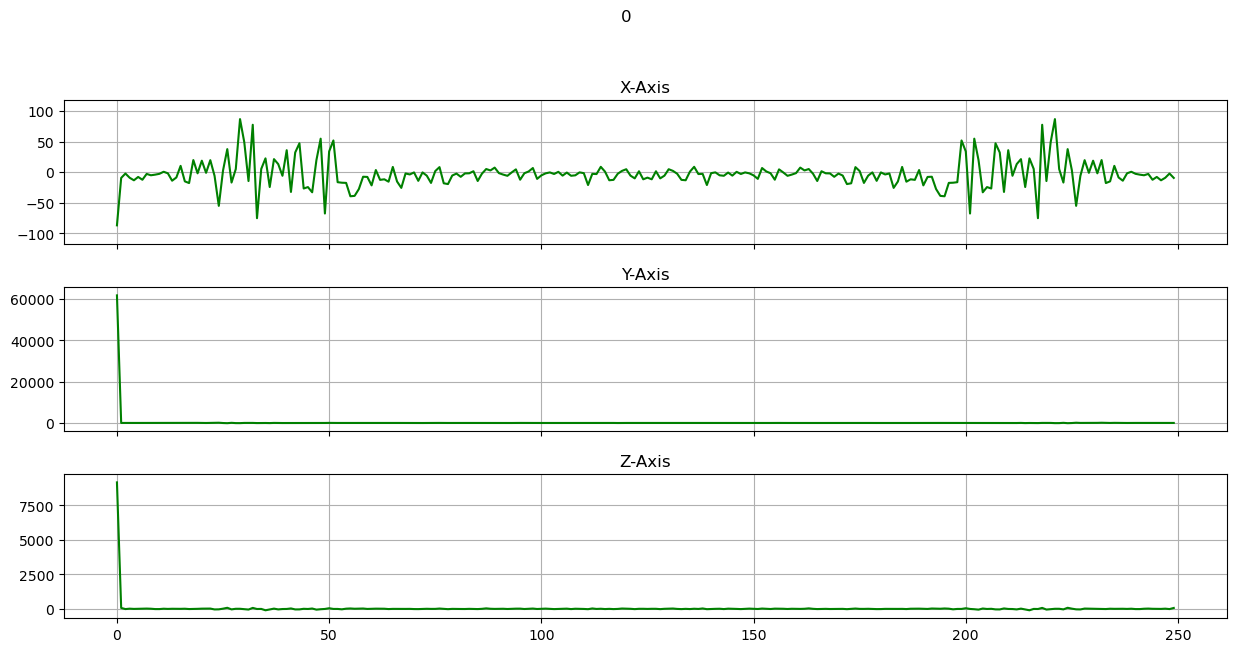

In [181]:
temp = data_051[(data_051['label'] == 0)][:Fs*10]
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis1(ax0,  np.fft.fft(temp['x']), 'X-Axis')
plot_axis1(ax1,  np.fft.fft(temp['y']), 'Y-Axis')
plot_axis1(ax2,  np.fft.fft(temp['z']), 'Z-Axis')
plt.subplots_adjust(hspace=0.3)
fig.suptitle(0)
plt.subplots_adjust(top=0.85)
plt.show()


Split data to train and test

In [182]:
df_train = df_all[df_all['id'] <= 161]
df_test = df_all[df_all['id']> 161]

Drop id and timestamps

In [183]:

df_train = df_train.drop(['id','timestamp','timestamp_raw'], axis=1)
df_test = df_test.drop(['id','timestamp','timestamp_raw'], axis=1)

In [184]:
df_train

,x,y,z,label
0,3,239,34,1
1,9,247,30,1
2,8,252,31,1
3,0,255,37,1
4,-12,252,39,1
...,...,...,...,...
4571,-1,243,42,0
4572,-1,244,41,0
4573,0,244,43,0
4574,-2,246,44,0


Window the data with a window size of 250, and a step_size of 50% of that, which is 125, also adding new engineered features based on the x, y, z value

In [185]:
def create_dataset(data, mode):
    x_list = []
    y_list = []
    z_list = []
    labels = []

    window_size = 250
    step_size = 125

    for i in range(0, data.shape[0] - window_size, step_size):
        xs = data['x'].values[i: i + 250]
        ys = data['y'].values[i: i + 250]
        zs = data['z'].values[i: i + 250]
        label = stats.mode(data['label'][i: i + 250],keepdims=True)[0][0]

        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        labels.append(label)
        
    X = pd.DataFrame()

    # Mean
    X['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
    X['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
    X['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

    # Stdev
    X['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
    X['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
    X['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

    # Min
    X['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
    X['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
    X['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

    # Max
    X['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
    X['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
    X['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

    # Median
    X['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
    X['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
    X['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

    # MAD 
    X['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # IQR
    X['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # Skewness
    X['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
    X['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
    X['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

    # Kurtosis
    X['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
    X['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
    X['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

    # Energy
    X['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/250)
    X['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/250)
    X['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/250))

    # Avg resultant accel
    X['avg_result_accel'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

    # SMA
    X['sma'] = pd.Series(x_list).apply(lambda x: np.sum(abs(x)/250)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/250)) + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/250))
    
    if mode == "fft":
        # converting the signals from time domain to frequency domain using FFT
        x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:251])
        y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:251])
        z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:251])

        # Statistical Features on raw x, y and z in frequency domain
        # FFT Mean
        X['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
        X['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
        X['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

        # FFT Stdev
        X['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
        X['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
        X['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

        # FFT Min
        X['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
        X['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
        X['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

        # FFT Max
        X['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
        X['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
        X['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

        # FFT Median
        X['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
        X['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
        X['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

        # FFT MAD 
        X['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
        X['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
        X['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

        # FFT IQR
        X['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
        X['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
        X['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

        # FFT Skewness
        X['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
        X['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
        X['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

        # FFT Kurtosis
        X['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
        X['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
        X['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

        # FFT Energy
        X['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/250)
        X['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/250)
        X['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/250))

        # FFT Avg resultant accel
        X['avg_result_accel_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

        # FFT SMA
        X['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/250)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/250)) + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/250))

    return X, np.array(labels)
        

Crate dataset using the create_dataset function

In [186]:
#Create without FFT features
X_train, Y_train = create_dataset(df_train,'no-fft')
X_test, Y_test = create_dataset(df_test, 'no-fft')
#Create with FFT features
X_FFT_train, Y_FFT_train = create_dataset(df_train,'fft')
X_FFT_test, Y_FFT_test = create_dataset(df_test,'fft')

I will plot a couple of the statistical measures that we have engineered from the base data

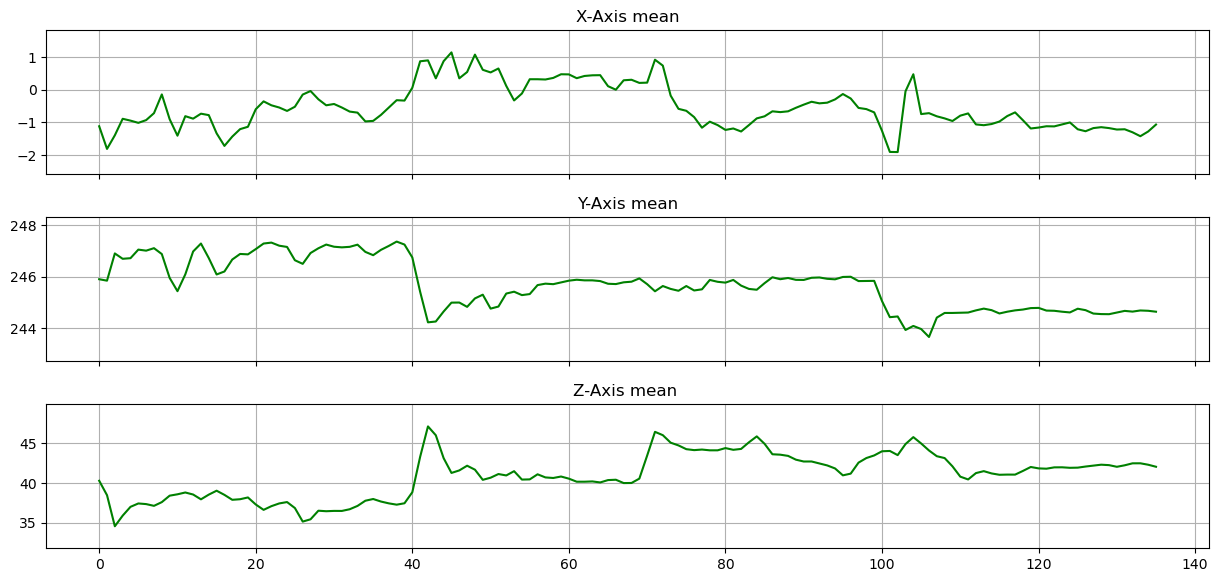

In [187]:
def plot_axis2(ax, y, title):
    ax.plot( y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(True)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

temp = X_train
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis2(ax0,  temp['x_mean'], 'X-Axis mean')
plot_axis2(ax1,  temp['y_mean'], 'Y-Axis mean')
plot_axis2(ax2,  temp['z_mean'], 'Z-Axis mean ')
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(top=0.85)
plt.show()


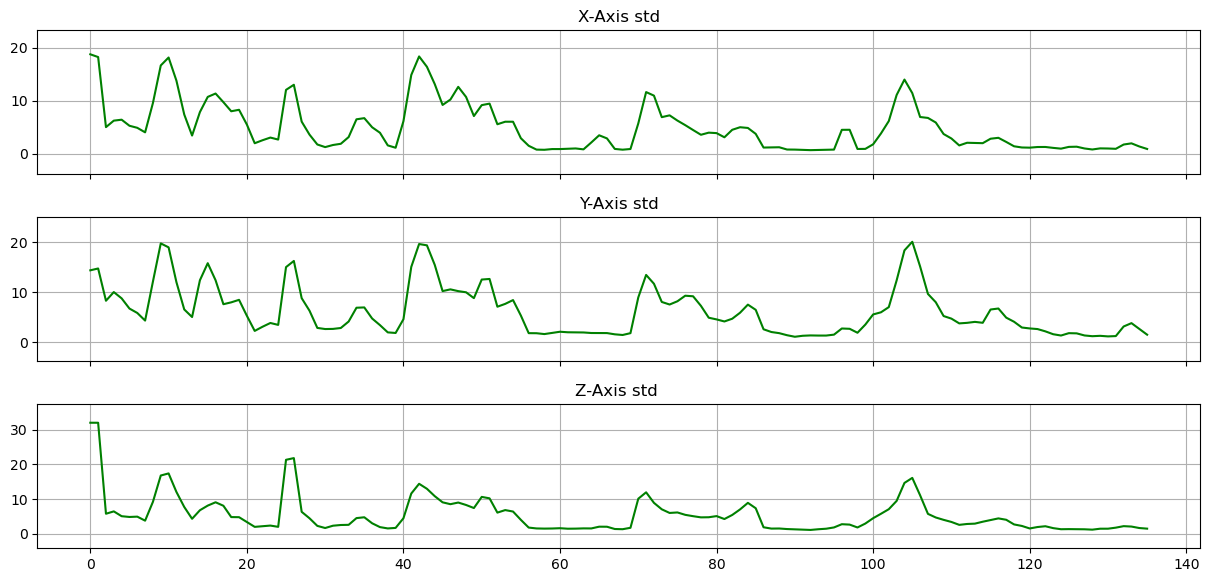

In [188]:
def plot_axis1(ax, y, title):
    ax.plot( y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(True)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

temp = X_train
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis1(ax0,  temp['x_std'], 'X-Axis std')
plot_axis1(ax1,  temp['y_std'], 'Y-Axis std')
plot_axis1(ax2,  temp['z_std'], 'Z-Axis std ')
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(top=0.85)
plt.show()


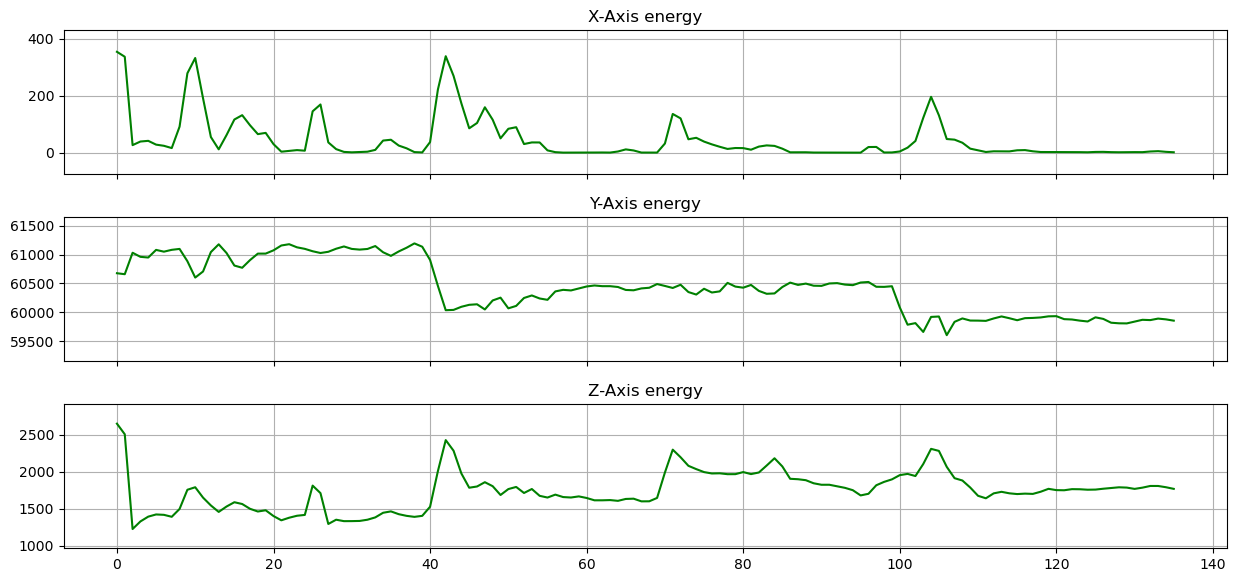

In [189]:
temp = X_train
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis2(ax0,  temp['x_energy'], 'X-Axis energy')
plot_axis2(ax1,  temp['y_energy'], 'Y-Axis energy')
plot_axis2(ax2,  temp['z_energy'], 'Z-Axis energy')
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(top=0.85)
plt.show()


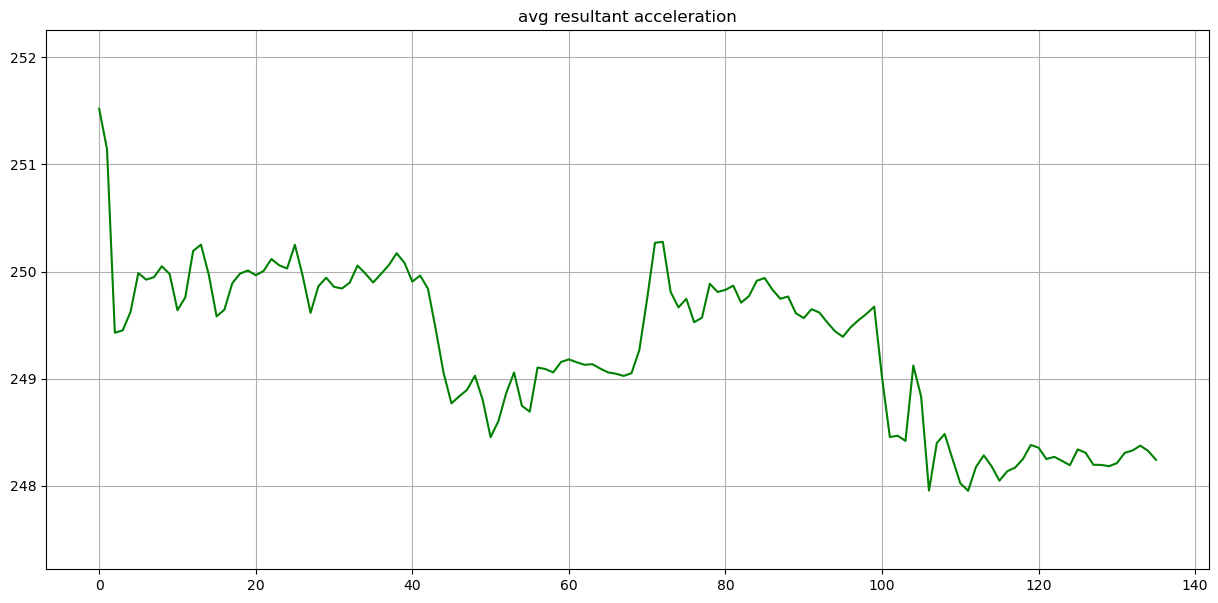

In [190]:
temp = X_train
fig, ax0 = plt.subplots(figsize=(15, 7))
plot_axis2(ax0,  temp['avg_result_accel'], 'avg resultant acceleration')
plt.show()


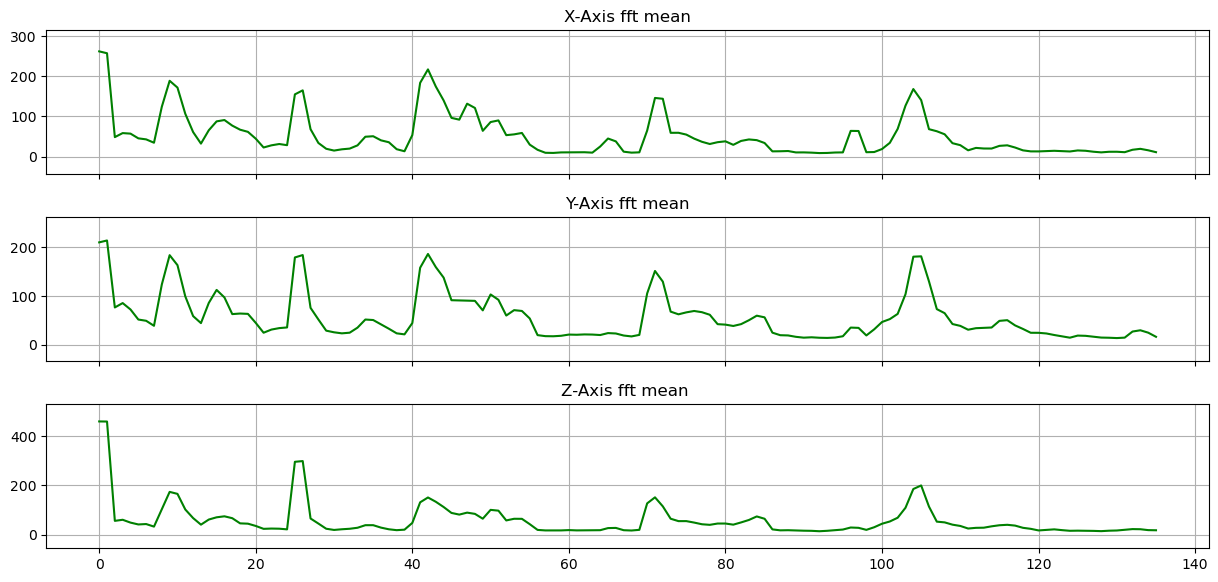

In [191]:
temp = X_FFT_train
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis2(ax0,  temp['x_mean_fft'], 'X-Axis fft mean')
plot_axis2(ax1,  temp['y_mean_fft'], 'Y-Axis fft mean')
plot_axis2(ax2,  temp['z_mean_fft'], 'Z-Axis fft mean ')
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(top=0.85)
plt.show()


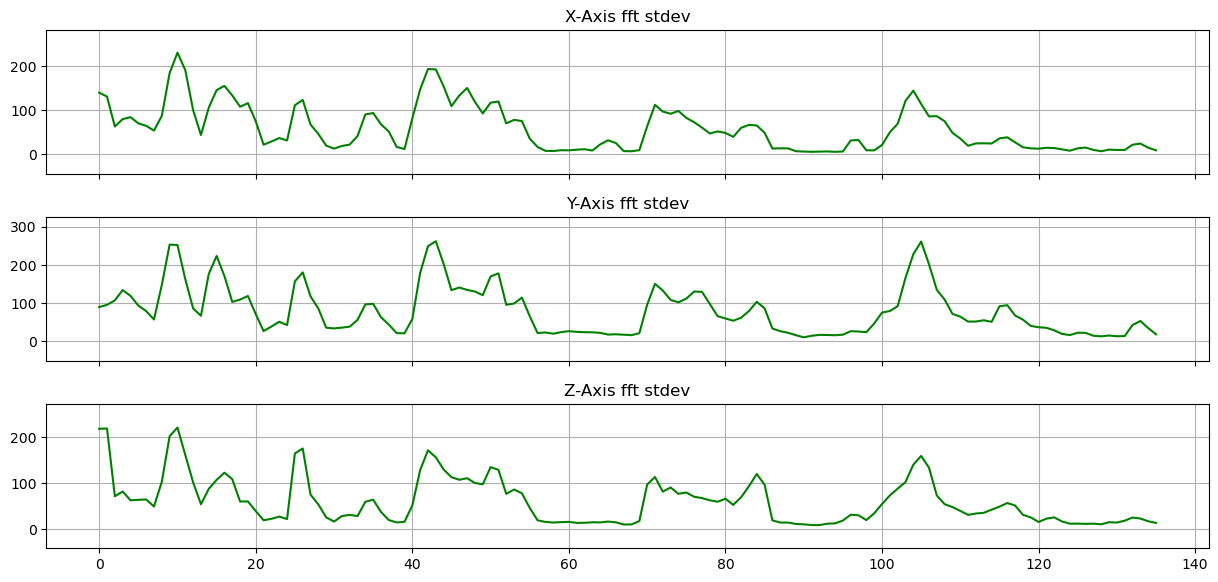

In [192]:
temp = X_FFT_train
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis2(ax0,  temp['x_std_fft'], 'X-Axis fft stdev')
plot_axis2(ax1,  temp['y_std_fft'], 'Y-Axis fft stdev')
plot_axis2(ax2,  temp['z_std_fft'], 'Z-Axis fft stdev')
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(top=0.85)
plt.show()


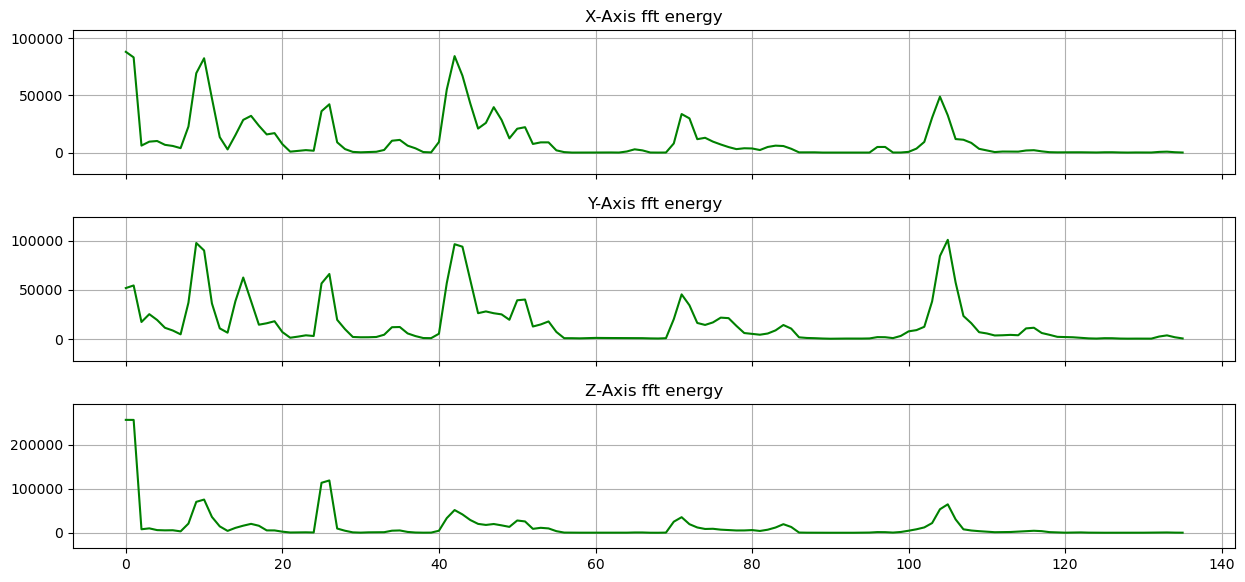

In [193]:
temp = X_FFT_train
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis2(ax0,  temp['x_energy_fft'], 'X-Axis fft energy')
plot_axis2(ax1,  temp['y_energy_fft'], 'Y-Axis fft energy')
plot_axis2(ax2,  temp['z_energy_fft'], 'Z-Axis fft energy')
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(top=0.85)
plt.show()


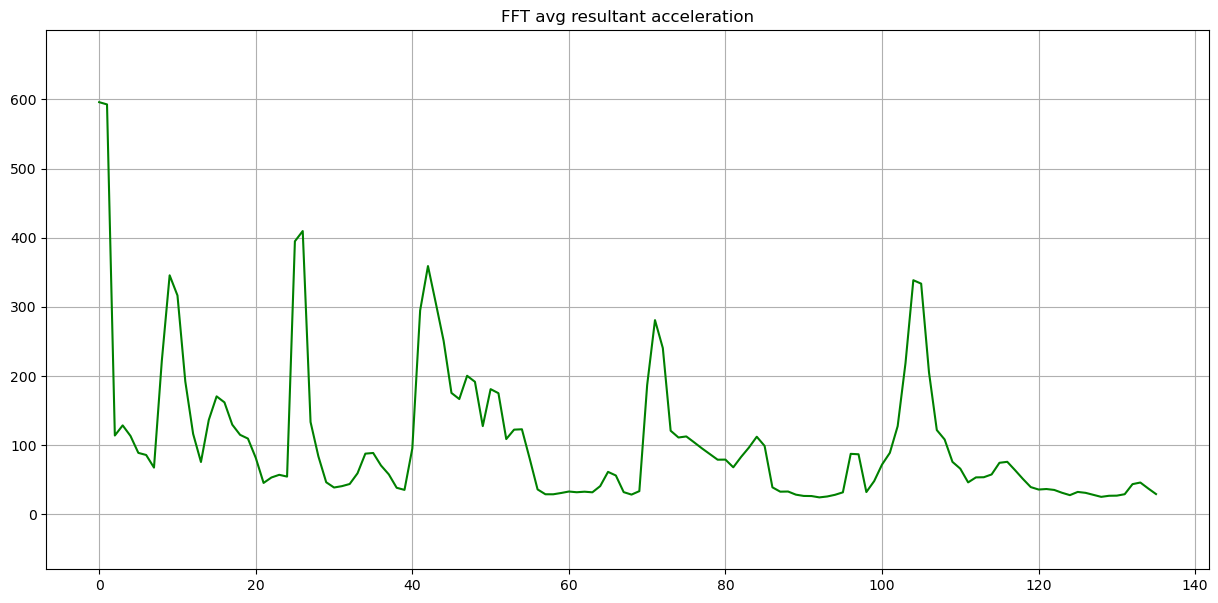

In [194]:
temp = X_FFT_train
fig, ax0 = plt.subplots(figsize=(15, 7))
plot_axis2(ax0,  temp['avg_result_accel_fft'], 'FFT avg resultant acceleration')
plt.show()


In [195]:
Y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [196]:
X_train.shape[0]

136

In [197]:
len(X_train.columns)

32

In [198]:
len(X_FFT_train.columns)

64

Make a function to fit a linear regression model and display classification results (precision, recall, f1, and accuracy) and also plot confusion matrix of the models predictions

In [199]:
def train_lr_model(X_train, X_test, Y_train, Y_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_data_lr = scaler.transform(X_train)
    X_test_data_lr = scaler.transform(X_test)
    lr = LogisticRegression(random_state = 22)
    lr.fit(X_data_lr, Y_train)
    y_pred = lr.predict(X_test_data_lr)
    print('-===== Logisitic Regression Results =====-')
    print(classification_report(Y_test, y_pred))
    conf_matrix = confusion_matrix(Y_test,y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot()
    plt.show()

Train LR model without FFT features and show the performance results

-===== Logisitic Regression Results =====-
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.88      1.00      0.94        23

    accuracy                           0.93        44
   macro avg       0.94      0.93      0.93        44
weighted avg       0.94      0.93      0.93        44



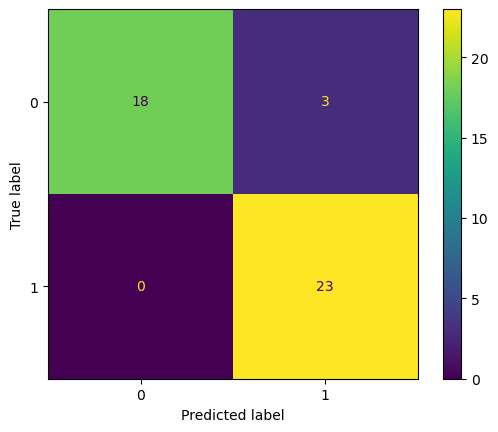

In [200]:
lr_no_fft = train_lr_model(X_train, X_test, Y_train, Y_test)

Train LR model with FFT features and show the performance results

-===== Logisitic Regression Results =====-
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        21
           1       0.82      1.00      0.90        23

    accuracy                           0.89        44
   macro avg       0.91      0.88      0.88        44
weighted avg       0.91      0.89      0.88        44



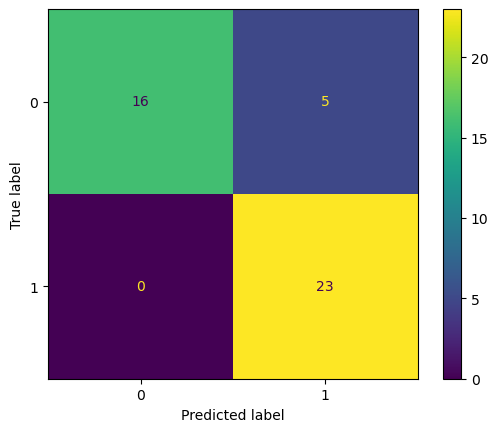

In [201]:
lr_fft = train_lr_model(X_FFT_train, X_FFT_test, Y_FFT_train, Y_FFT_test)

Make a function to fit a random forest model and display classification results (precision, recall, f1, and accuracy) and also plot confusion matrix of the models predictions

In [202]:
def train_rf_model(X_train, X_test, Y_train, Y_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_data_lr = scaler.transform(X_train)
    X_test_data_lr = scaler.transform(X_test)
    rf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=100,oob_score=True)
    rf.fit(X_data_lr, Y_train)
    y_pred = rf.predict(X_test_data_lr)
    print('-===== Random Forest Results =====-')
    print(classification_report(Y_test, y_pred))
    conf_matrix = confusion_matrix(Y_test,y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot()
    print('OOB Score: '+ str(rf.oob_score_))
    plt.show()

Train RF model without FFT features and show the performance results

-===== Random Forest Results =====-
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        21
           1       0.82      1.00      0.90        23

    accuracy                           0.89        44
   macro avg       0.91      0.88      0.88        44
weighted avg       0.91      0.89      0.88        44

OOB Score: 0.9191176470588235


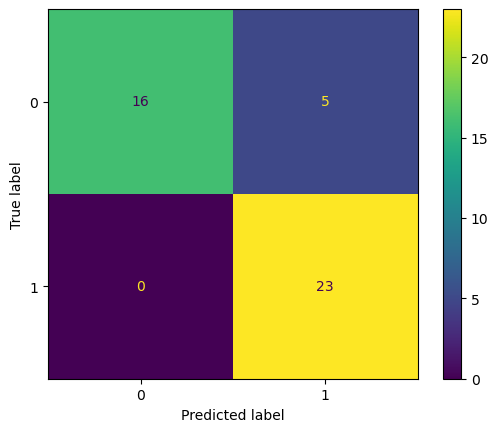

In [203]:
rf_no_fft = train_rf_model(X_train, X_test, Y_train, Y_test)

Train LR model with FFT features and show the performance results

-===== Random Forest Results =====-
              precision    recall  f1-score   support

           0       1.00      0.62      0.76        21
           1       0.74      1.00      0.85        23

    accuracy                           0.82        44
   macro avg       0.87      0.81      0.81        44
weighted avg       0.87      0.82      0.81        44

OOB Score: 0.9044117647058824


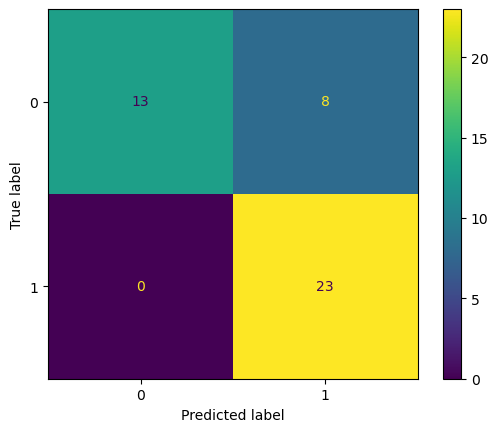

In [204]:
rf_fft = train_rf_model(X_FFT_train, X_FFT_test, Y_FFT_train, Y_FFT_test)